In [ ]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Text preprocessing
import re
import string
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, pipeline
import torch

In [ ]:
from google.colab import files

# Upload the kaggle.json file
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farzeenshahid","key":"19710366d8c39894f573eb57b51ccb1d"}'}

In [ ]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
!mv kaggle.json ~/.kaggle/

# Set file permissions to read-only
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Use Kaggle API to download the Sephora dataset
!kaggle datasets download -d nadyinky/sephora-products-and-skincare-reviews

# Unzip the dataset
!unzip sephora-products-and-skincare-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 145M/147M [00:06<00:00, 30.4MB/s]
100% 147M/147M [00:06<00:00, 23.4MB/s]
Archive:  sephora-products-and-skincare-reviews.zip
  inflating: product_info.csv        
  inflating: reviews_0-250.csv       
  inflating: reviews_1250-end.csv    
  inflating: reviews_250-500.csv     
  inflating: reviews_500-750.csv     
  inflating: reviews_750-1250.csv    


In [ ]:
import pandas as pd

df = pd.read_csv('reviews_0-250.csv')
df1 = df[df['brand_name'] == 'The INKEY List']
# Display the first few rows of the combined DataFrame
df1.head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
244328,244328,12257249172,3,0.0,NaN,0,0,0,2023-03-21,The first few times I used this product I like...,NaN,fairLight,brown,oily,blonde,P455364,Oat Cleansing Balm,The INKEY List,11.99
244329,244329,312867418,4,1.0,NaN,0,0,0,2023-03-21,I used this cleanser as the first step in my c...,Removes makeup well,fair,blue,combination,blonde,P455364,Oat Cleansing Balm,The INKEY List,11.99
244330,244330,37811748871,5,1.0,NaN,0,0,0,2023-03-21,My first impression of this product was simply...,A must have in my nighttime skincare routine!,NaN,brown,combination,black,P455364,Oat Cleansing Balm,The INKEY List,11.99
244331,244331,6211475875,5,1.0,1.0,1,0,1,2023-03-21,One of the best balms out there. I usually get...,A must try,NaN,brown,oily,NaN,P455364,Oat Cleansing Balm,The INKEY List,11.99
244332,244332,9562923176,3,0.0,0.5,2,1,1,2023-03-20,This feels like a making cleansing balm but do...,Leaves my face greasy and clogged,NaN,blue,normal,blonde,P455364,Oat Cleansing Balm,The INKEY List,11.99


In [ ]:
df1.drop(['Unnamed: 0', 'author_id', 'rating', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd'], axis=1,inplace=True)

In [ ]:
df1.shape

(11122, 2)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11122 entries, 244328 to 497402
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   is_recommended  11122 non-null  float64
 1   review_text     11110 non-null  object 
dtypes: float64(1), object(1)
memory usage: 518.7+ KB


In [ ]:
df1.dropna(inplace=True)
df1.drop_duplicates(inplace=True)

In [ ]:
# Preprocessing and Labeling
df1['label'] = df1['is_recommended']
df1['label'] = df1['label'].apply(lambda x: 1 if x == 1 else 0)  # 1 for recommended, 0 for not recommended
df1 = df1[['review_text', 'label']]



In [ ]:
#limiting the dataset for faster training - >>>>> REMOVE THIS <<<<<
df1 =df1[:8000]
#df = df[:5000]

In [ ]:

# Text cleaning function
def clean_text(text):
    stop = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemma.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop]
    return " ".join(tokens)


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
!pip install swifter

In [ ]:
import swifter

In [ ]:
# Apply cleaning by vectorizing it for faster cleaning
df1['text'] = df1['review_text'].swifter.apply(clean_text)


Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

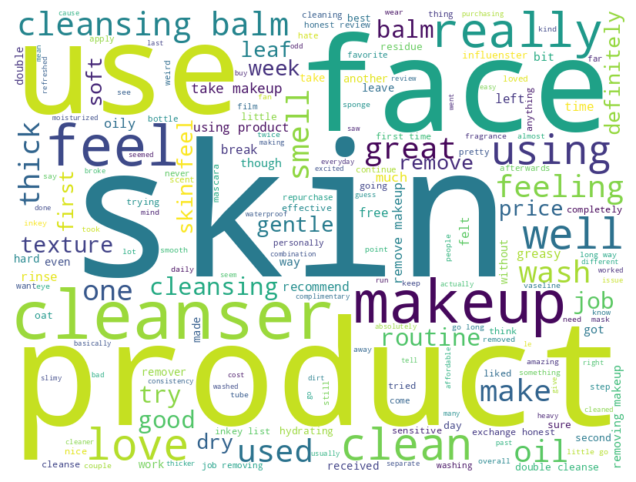

In [ ]:
# Visualize data
allwords = ' '.join(word for word in df1['text'])
wordcloud = WordCloud(width=800, height=600, background_color='white').generate(allwords)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [ ]:
# Logistic Regression Baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


In [ ]:
# Split data
X = df1['text']
y = df1['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
vec = TfidfVectorizer()
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)


In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_vec, y_train)
y_pred_log_reg = log_reg.predict(X_test_vec)

In [ ]:
# Evaluation function
def evaluation_metrics(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

--- Logistic Regression Baseline ---
Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.75      1.00      0.86        15

    accuracy                           0.75        20
   macro avg       0.38      0.50      0.43        20
weighted avg       0.56      0.75      0.64        20



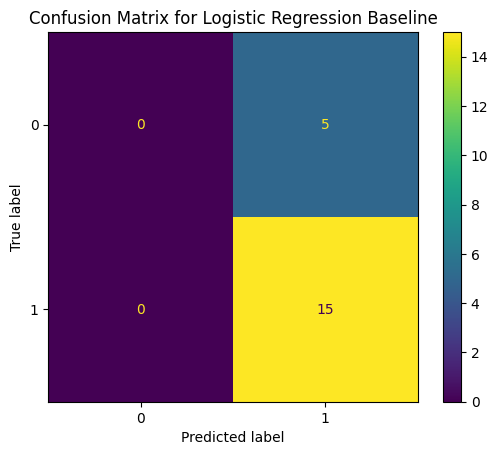

In [ ]:
# Evaluate Logistic Regression Baseline model
evaluation_metrics(y_test, y_pred_log_reg, "Logistic Regression Baseline")

In [ ]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [ ]:

candidate_labels=["positive", "negative", "neutral"]

def zero_shot_classify(review_text):
    prompt = (
        f"Classify the following review as positive, negative, or neutral:\n"
        f"Review: '{review_text}'"
    )
    # Perform the classification
    result = classifier(prompt, candidate_labels=candidate_labels)
    sentiment = result["labels"][0]
    return sentiment  # Return only the sentiment

# Apply zero-shot prompting to a list of reviews
predictions = [zero_shot_classify(review) for review in X_test]

# Print results
for review, sentiment in zip(X_test, predictions):
    print(f"Review: {review}, Sentiment: {sentiment}")



Review: using product week find great making skin feel clean combination skin find little greasy liking take actually wash like feel like makeup good price think personally purchase great making sure, Sentiment: positive
Review: product pretty amazing taking makeup even broke lash glue without issue however feel like heavy ointment going double cleanse sure skin feel soft clean though highly recommend, Sentiment: positive
Review: like sadden say truth sephora week ago excited learn inkey list know someone seen great result brand saw skin asked use went sephora trying figure product try inkey list first well got oat cleanser complimentary influenster try immediately squeezed tube oil came smell good weird bland smell soon put face immediately said oh good felt like vaseline face rinse matter many time tried rinse feel clean sad write review saying like honest definitely try inkey list product glad got try, Sentiment: negative
Review: gusta la textura de este limpiador deja la piel fresc

In [ ]:
# Map sentiments to binary labels
def map_sentiment_to_label(sentiment):
    if sentiment == "positive":
        return 1
    elif sentiment == "negative":
        return 0
    else:
        return 0

# Apply mapping
predictions_mapped = [map_sentiment_to_label(sentiment) for sentiment in predictions]


In [ ]:
# Ensure y_test is in string format
y_test_int = y_test.astype(int).values  # Convert to string if needed

--- Zero-Shot Classify ---
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.88      0.93      0.90        15

    accuracy                           0.85        20
   macro avg       0.81      0.77      0.78        20
weighted avg       0.84      0.85      0.84        20



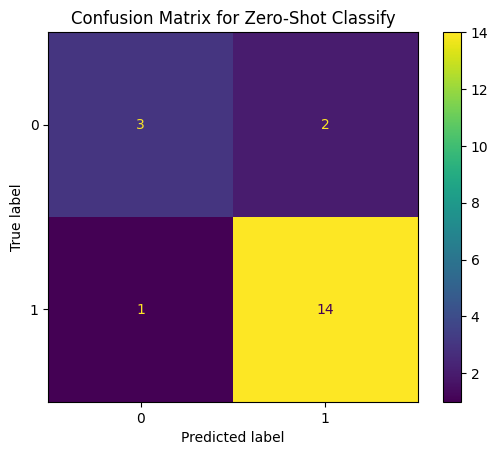

In [ ]:
evaluation_metrics(y_test_int, predictions_mapped, model_name="Zero-Shot Classify")